In [1]:
%pylab inline

from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


In [2]:
wav_wildcard_fp = 'wav_database/*/*.wav'

import glob
import os
import re
from scipy.io.wavfile import read as wavread

cipic_regex = re.compile(r'wav_database\\subject(\d{1,3})\\(neg)?(\d{1,2})az(left|right).wav')
def cipic_search(cipic_wav_fp):
    match = cipic_regex.match(cipic_wav_fp)
    subject = int(match.group(1))
    azimuth = (-1 if match.group(2) else 1) * int(match.group(3))
    channel = 0 if match.group(4) == 'left' else 1
    return (subject, azimuth, channel)

hrir_wav_fps = glob.glob(wav_wildcard_fp)
hrir_wav_fps = filter(cipic_regex.match, hrir_wav_fps)
hrir_wav_fps = sorted(hrir_wav_fps, key=lambda x: cipic_search(x))

azimuths = '-80 -65 -55 -45 -40 -35 -30 -25 -20 -15 -10 -5 0 5 10 15 20 25 30 35 40 45 55 65 80'
azimuths = [int(x) for x in azimuths.split()]
elevations = '-45 -39 -34 -28 -23 -17 -11 -6 0 6 11 17 23 28 34 39 45 51 56 62 68 73 79 84 90 96 101 107 113 118 124 129 135 141 146 152 158 163 169 174 180 186 191 197 203 208 214 219 225 231'
elevations = [int(x) for x in elevations.split()]

subjects = {}
for wav_fp in hrir_wav_fps:
    subject, azimuth, channel = cipic_search(wav_fp)
    
    if subject not in subjects:
        subjects[subject] = []
        
    fs, hrir = wavread(wav_fp)
    ele_row = []
    for i in xrange(hrir.shape[0]):
        ele_row.append(hrir[i])
    subjects[subject].append(ele_row)

In [3]:
subject_ids = sorted(subjects.keys())
data = [subjects[i] for i in subject_ids]
data = np.array(data)
data = data.astype(np.float64) / 32768.0
# data is (subjects, azimuths, elevations, ir)
print data.dtype
print data.shape
print data.min()
print data.max()
print data.std()
subject_to_idx = {k:i for i, k in enumerate(subject_ids)}
azimuth_to_idx = {k:i for i, k in enumerate(azimuths)}
elevation_to_idx = {k:i for i, k in enumerate(elevations)}
data_access = lambda x, y, z: data[subject_to_idx[x]][azimuth_to_idx[y]][elevation_to_idx[z]]
print data_access(3, -35, 101).shape

float64
(45L, 50L, 50L, 200L)
-0.9033203125
0.710113525391
0.0304762454271
(200L,)


In [37]:
# Retrieve all azimuth data for one subject at elevation 0deg

pca_data = data[subject_to_idx[10], :, elevation_to_idx[0], :]
print pca_data.shape
pca_data = np.reshape(pca_data, (-1, 200))
pca = PCA(n_components=19)
pca.fit(pca_data)
print sum(pca.explained_variance_ratio_)

# Good heuristic is to tune n_components to explain 99% of variance
# http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/

(50L, 200L)
0.986512049795


(19L, 200L)


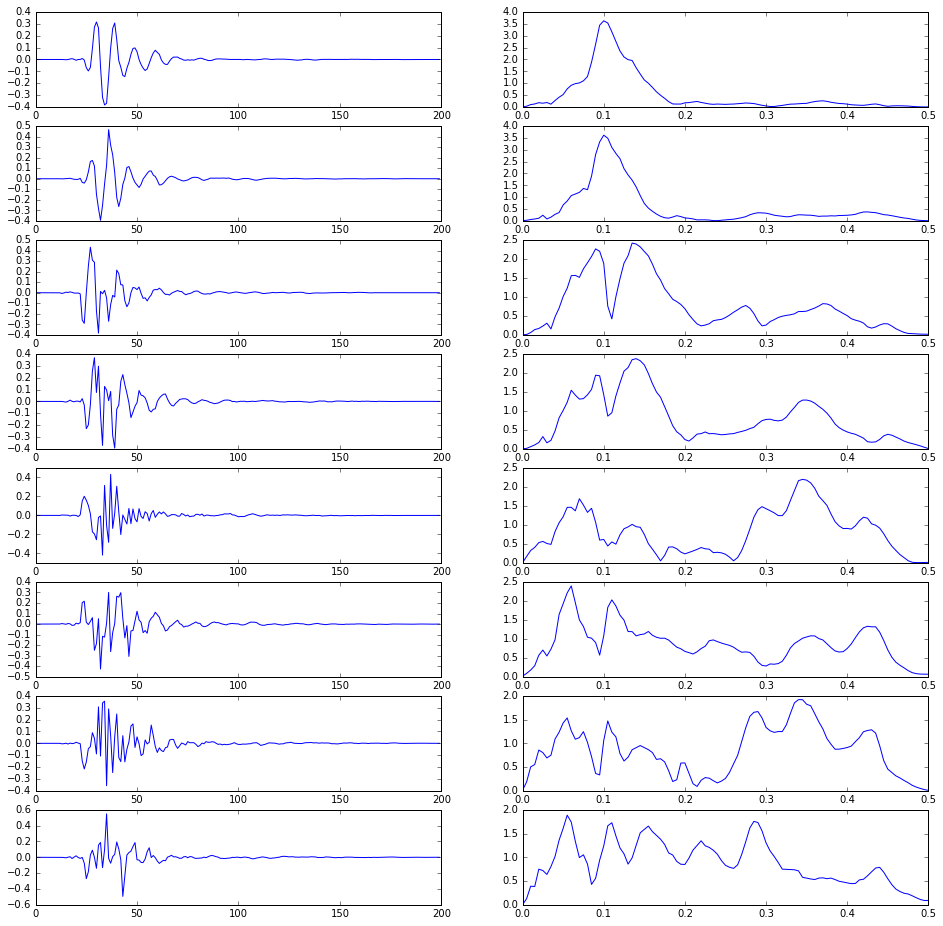

In [38]:
# Inspect the first 8 components in time and freq domain
# PCA is orthogonal transform so doesn't matter if we employ in time or freq domoain

ninspect = 8
print pca.components_.shape
f, axarr = plt.subplots(ninspect, 2, figsize=(16, 16))
freqx = numpy.fft.rfftfreq(200)
for i in xrange(ninspect):
    component = pca.components_[i]
    axarr[i][0].plot(component)
    axarr[i][1].plot(freqx, np.abs(np.fft.rfft(component)))

Mean squared error: 0.0022387029673
Mean squared error PCA: 0.00223432536915


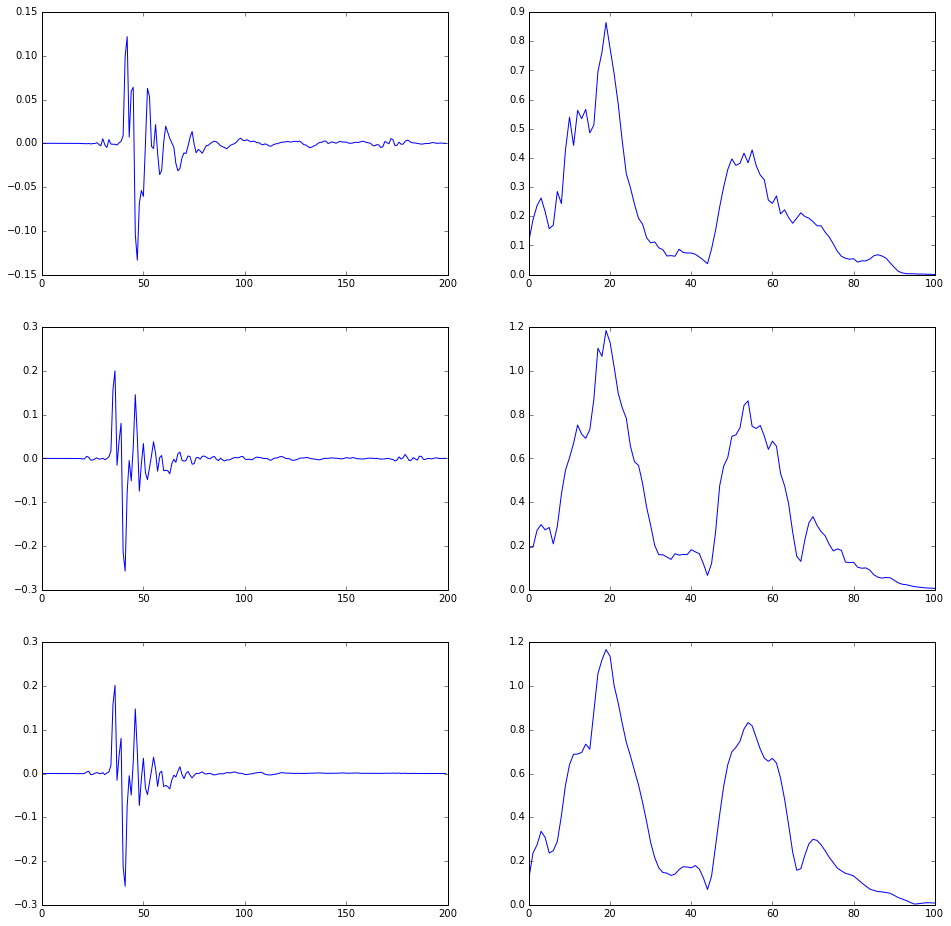

In [34]:
# Use reduced data to try to interpolate the az35 HRIR and compare to ground truth

az30 = data[subject_to_idx[3], azimuth_to_idx[30], elevation_to_idx[0]]
az35 = data[subject_to_idx[3], azimuth_to_idx[35], elevation_to_idx[0]]
az40 = data[subject_to_idx[3], azimuth_to_idx[40], elevation_to_idx[0]]

# Linear interpolation in time
az35_predicted = (az30 + az40) / 2.0

# Linear interpolation in space of transform
az30_reduced = pca.transform(np.reshape(az30, (1, -1)))
az40_reduced = pca.transform(np.reshape(az40, (1, -1)))
az35_predicted_reduced = (az30_reduced + az40_reduced) / 2.0
az35_predicted_pca = pca.inverse_transform(az35_predicted_reduced)[0]

print 'Mean squared error: {}'.format(np.mean((az35 - az35_predicted) ** 2.0))
print 'Mean squared error PCA: {}'.format(np.mean((az35 - az35_predicted_pca) ** 2.0))

f, axarr = plt.subplots(3, 2, figsize=(16, 16))
axarr[0][0].plot(az35)
axarr[0][1].plot(np.abs(np.fft.rfft(az35)))
axarr[1][0].plot(az35_predicted)
axarr[1][1].plot(np.abs(np.fft.rfft(az35_predicted)))
axarr[2][0].plot(az35_predicted_pca)
axarr[2][1].plot(np.abs(np.fft.rfft(az35_predicted_pca)))